In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
date = "20190830"
run_name = "08_30_2019_run_01"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [12]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[13:25:11 - __main__] Getting molbit sequences.
[13:25:11 - __main__] Locating fastq files.
[13:25:11 - __main__] Running SW, one fastq at a time.
[13:25:11 - __main__] Starting fastq (0 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_0.fastq


[########################################] | 100% Completed | 30.8s


[13:25:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_0.tsv
[13:25:42 - __main__] Starting fastq (1 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_1.fastq


[########################################] | 100% Completed | 27.0s


[13:26:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_1.tsv
[13:26:09 - __main__] Starting fastq (2 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_2.fastq


[########################################] | 100% Completed | 49.7s


[13:26:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_2.tsv
[13:26:59 - __main__] Starting fastq (3 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_3.fastq


[########################################] | 100% Completed | 37.5s


[13:27:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_0_3.tsv
[13:27:37 - __main__] Starting fastq (4 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_0.fastq


[########################################] | 100% Completed | 47.4s


[13:28:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_0.tsv
[13:28:25 - __main__] Starting fastq (5 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_1.fastq


[########################################] | 100% Completed | 39.7s


[13:29:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_1.tsv
[13:29:05 - __main__] Starting fastq (6 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_2.fastq


[########################################] | 100% Completed | 59.1s


[13:30:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_2.tsv
[13:30:05 - __main__] Starting fastq (7 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_3.fastq


[########################################] | 100% Completed |  4.6s


[13:30:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_1_3.tsv
[13:30:10 - __main__] Starting fastq (8 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_0.fastq


[########################################] | 100% Completed | 45.6s


[13:30:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_0.tsv
[13:30:56 - __main__] Starting fastq (9 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_1.fastq


[########################################] | 100% Completed | 46.6s


[13:31:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_1.tsv
[13:31:43 - __main__] Starting fastq (10 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_2.fastq


[########################################] | 100% Completed | 48.4s


[13:32:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_2.tsv
[13:32:32 - __main__] Starting fastq (11 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_3.fastq


[########################################] | 100% Completed |  5.9s


[13:32:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_2_3.tsv
[13:32:38 - __main__] Starting fastq (12 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_0.fastq


[########################################] | 100% Completed | 32.4s


[13:33:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_0.tsv
[13:33:10 - __main__] Starting fastq (13 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_1.fastq


[########################################] | 100% Completed |  1min 48.7s


[13:34:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_1.tsv
[13:35:00 - __main__] Starting fastq (14 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_0.fastq


[########################################] | 100% Completed |  1min  3.2s


[13:36:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_0.tsv
[13:36:03 - __main__] Starting fastq (15 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_2.fastq


[########################################] | 100% Completed |  1.0s


[13:36:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_2.tsv
[13:36:05 - __main__] Starting fastq (16 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_1.fastq


[########################################] | 100% Completed | 29.8s


[13:36:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_1.tsv
[13:36:35 - __main__] Starting fastq (17 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_3.fastq


[########################################] | 100% Completed |  7.1s


[13:36:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_3_3.tsv
[13:36:42 - __main__] Starting fastq (18 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_0.fastq


[########################################] | 100% Completed | 49.3s


[13:37:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_0.tsv
[13:37:32 - __main__] Starting fastq (19 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_2.fastq


[########################################] | 100% Completed | 57.4s


[13:38:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_2.tsv
[13:38:30 - __main__] Starting fastq (20 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_1.fastq


[########################################] | 100% Completed |  1min  6.0s


[13:39:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_1.tsv
[13:39:37 - __main__] Starting fastq (21 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_2.fastq


[########################################] | 100% Completed | 15.1s


[13:39:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_2.tsv
[13:39:52 - __main__] Starting fastq (22 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_0.fastq


[########################################] | 100% Completed | 58.6s


[13:40:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_0.tsv
[13:40:51 - __main__] Starting fastq (23 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_3.fastq


[########################################] | 100% Completed |  1.4s


[13:40:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_4_3.tsv
[13:40:53 - __main__] Starting fastq (24 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_3.fastq


[########################################] | 100% Completed | 20.8s


[13:41:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_5_3.tsv
[13:41:14 - __main__] Starting fastq (25 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_1.fastq


[########################################] | 100% Completed | 38.0s


[13:41:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_1.tsv
[13:41:52 - __main__] Starting fastq (26 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_2.fastq


[########################################] | 100% Completed | 23.6s


[13:42:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_2.tsv
[13:42:16 - __main__] Starting fastq (27 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_3.fastq


[########################################] | 100% Completed | 27.6s


[13:42:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_6_3.tsv
[13:42:44 - __main__] Starting fastq (28 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_0.fastq


[########################################] | 100% Completed | 36.7s


[13:43:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_0.tsv
[13:43:21 - __main__] Starting fastq (29 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_1.fastq


[########################################] | 100% Completed | 36.1s


[13:43:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_1.tsv
[13:43:58 - __main__] Starting fastq (30 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_2.fastq


[########################################] | 100% Completed | 53.7s


[13:44:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_2.tsv
[13:44:52 - __main__] Starting fastq (31 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_3.fastq


[########################################] | 100% Completed | 24.8s


[13:45:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_7_3.tsv
[13:45:17 - __main__] Starting fastq (32 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_0.fastq


[########################################] | 100% Completed |  1min 15.6s


[13:46:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_0.tsv
[13:46:33 - __main__] Starting fastq (33 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_1.fastq


[########################################] | 100% Completed | 31.5s


[13:47:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_1.tsv
[13:47:05 - __main__] Starting fastq (34 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_2.fastq


[########################################] | 100% Completed | 31.3s


[13:47:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_2.tsv
[13:47:37 - __main__] Starting fastq (35 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_3.fastq


[########################################] | 100% Completed | 15.7s


[13:47:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_8_3.tsv
[13:47:53 - __main__] Starting fastq (36 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_0.fastq


[########################################] | 100% Completed | 27.5s


[13:48:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_0.tsv
[13:48:21 - __main__] Starting fastq (37 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_1.fastq


[########################################] | 100% Completed | 39.3s


[13:49:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_1.tsv
[13:49:00 - __main__] Starting fastq (38 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_2.fastq


[########################################] | 100% Completed | 38.9s


[13:49:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_2.tsv
[13:49:40 - __main__] Starting fastq (39 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_3.fastq


[########################################] | 100% Completed | 44.1s


[13:50:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_9_3.tsv
[13:50:24 - __main__] Starting fastq (40 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_0.fastq


[########################################] | 100% Completed |  1min 47.5s


[13:52:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_0.tsv
[13:52:12 - __main__] Starting fastq (41 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_1.fastq


[########################################] | 100% Completed | 14.0s


[13:52:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_1.tsv
[13:52:27 - __main__] Starting fastq (42 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_0.fastq


[########################################] | 100% Completed |  1min 10.9s


[13:53:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_0.tsv
[13:53:38 - __main__] Starting fastq (43 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_2.fastq


[########################################] | 100% Completed | 25.9s


[13:54:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_2.tsv
[13:54:04 - __main__] Starting fastq (44 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_3.fastq


[########################################] | 100% Completed |  1.0s


[13:54:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_10_3.tsv
[13:54:06 - __main__] Starting fastq (45 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_1.fastq


[########################################] | 100% Completed | 37.0s


[13:54:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_1.tsv
[13:54:43 - __main__] Starting fastq (46 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_2.fastq


[########################################] | 100% Completed | 32.5s


[13:55:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_2.tsv
[13:55:16 - __main__] Starting fastq (47 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_3.fastq


[########################################] | 100% Completed |  9.6s


[13:55:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_11_3.tsv
[13:55:26 - __main__] Starting fastq (48 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_0.fastq


[########################################] | 100% Completed | 50.2s


[13:56:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_0.tsv
[13:56:16 - __main__] Starting fastq (49 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_1.fastq


[########################################] | 100% Completed | 46.2s


[13:57:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_1.tsv
[13:57:03 - __main__] Starting fastq (50 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_2.fastq


[########################################] | 100% Completed | 28.6s


[13:57:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_2.tsv
[13:57:32 - __main__] Starting fastq (51 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_3.fastq


[########################################] | 100% Completed | 26.4s


[13:57:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_12_3.tsv
[13:57:59 - __main__] Starting fastq (52 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_0.fastq


[########################################] | 100% Completed | 40.8s


[13:58:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_0.tsv
[13:58:40 - __main__] Starting fastq (53 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_1.fastq


[########################################] | 100% Completed | 35.1s


[13:59:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_1.tsv
[13:59:16 - __main__] Starting fastq (54 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_2.fastq


[########################################] | 100% Completed | 46.6s


[14:00:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_2.tsv
[14:00:02 - __main__] Starting fastq (55 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_3.fastq


[########################################] | 100% Completed | 27.8s


[14:00:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_13_3.tsv
[14:00:31 - __main__] Starting fastq (56 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_0.fastq


[########################################] | 100% Completed |  1min  0.3s


[14:01:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_0.tsv
[14:01:31 - __main__] Starting fastq (57 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_1.fastq


[########################################] | 100% Completed |  7.1s


[14:01:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_1.tsv
[14:01:39 - __main__] Starting fastq (58 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_2.fastq


[########################################] | 100% Completed | 59.1s


[14:02:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_2.tsv
[14:02:38 - __main__] Starting fastq (59 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_3.fastq


[########################################] | 100% Completed | 22.6s


[14:03:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_14_3.tsv
[14:03:01 - __main__] Starting fastq (60 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_0.fastq


[########################################] | 100% Completed | 47.7s


[14:03:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_0.tsv
[14:03:50 - __main__] Starting fastq (61 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_1.fastq


[########################################] | 100% Completed |  1min  4.0s


[14:04:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_1.tsv
[14:04:54 - __main__] Starting fastq (62 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_2.fastq


[########################################] | 100% Completed | 20.5s


[14:05:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_2.tsv
[14:05:15 - __main__] Starting fastq (63 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_0.fastq


[########################################] | 100% Completed | 50.3s


[14:06:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_0.tsv
[14:06:06 - __main__] Starting fastq (64 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_3.fastq


[########################################] | 100% Completed | 17.3s


[14:06:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_15_3.tsv
[14:06:23 - __main__] Starting fastq (65 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_1.fastq


[########################################] | 100% Completed |  1min  9.7s


[14:07:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_1.tsv
[14:07:34 - __main__] Starting fastq (66 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_2.fastq


[########################################] | 100% Completed | 14.6s


[14:07:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_2.tsv
[14:07:48 - __main__] Starting fastq (67 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_0.fastq


[########################################] | 100% Completed | 57.4s


[14:08:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_0.tsv
[14:08:46 - __main__] Starting fastq (68 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_1.fastq


[########################################] | 100% Completed |  1min  6.4s


[14:09:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_1.tsv
[14:09:53 - __main__] Starting fastq (69 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_3.fastq


[########################################] | 100% Completed | 17.8s


[14:10:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_16_3.tsv
[14:10:11 - __main__] Starting fastq (70 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_2.fastq


[########################################] | 100% Completed | 11.5s


[14:10:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_2.tsv
[14:10:23 - __main__] Starting fastq (71 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_3.fastq


[########################################] | 100% Completed | 11.6s


[14:10:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_17_3.tsv
[14:10:35 - __main__] Starting fastq (72 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_0.fastq


[########################################] | 100% Completed | 36.1s


[14:11:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_0.tsv
[14:11:12 - __main__] Starting fastq (73 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_1.fastq


[########################################] | 100% Completed |  1min 31.7s


[14:12:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_1.tsv
[14:12:44 - __main__] Starting fastq (74 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_2.fastq


[########################################] | 100% Completed | 18.5s


[14:13:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_2.tsv
[14:13:03 - __main__] Starting fastq (75 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_0.fastq


[########################################] | 100% Completed | 46.0s


[14:13:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_0.tsv
[14:13:49 - __main__] Starting fastq (76 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_1.fastq


[########################################] | 100% Completed |  1min  5.5s


[14:14:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_1.tsv
[14:14:55 - __main__] Starting fastq (77 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_3.fastq


[########################################] | 100% Completed |  0.9s


[14:14:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_18_3.tsv
[14:14:56 - __main__] Starting fastq (78 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_2.fastq


[########################################] | 100% Completed | 22.8s


[14:15:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_2.tsv
[14:15:19 - __main__] Starting fastq (79 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_0.fastq


[########################################] | 100% Completed |  1min 19.4s


[14:16:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_0.tsv
[14:16:39 - __main__] Starting fastq (80 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_1.fastq


[########################################] | 100% Completed | 29.3s


[14:17:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_1.tsv
[14:17:09 - __main__] Starting fastq (81 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_2.fastq


[########################################] | 100% Completed | 32.7s


[14:17:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_2.tsv
[14:17:42 - __main__] Starting fastq (82 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_3.fastq


[########################################] | 100% Completed |  9.4s


[14:17:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_19_3.tsv
[14:17:52 - __main__] Starting fastq (83 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_0.fastq


[########################################] | 100% Completed | 49.9s


[14:18:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_0.tsv
[14:18:42 - __main__] Starting fastq (84 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_3.fastq


[########################################] | 100% Completed |  5.3s


[14:18:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_20_3.tsv
[14:18:48 - __main__] Starting fastq (85 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_1.fastq


[########################################] | 100% Completed | 26.0s


[14:19:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_1.tsv
[14:19:14 - __main__] Starting fastq (86 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_2.fastq


[########################################] | 100% Completed | 58.5s


[14:20:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_2.tsv
[14:20:13 - __main__] Starting fastq (87 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_3.fastq


[########################################] | 100% Completed | 11.9s


[14:20:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_21_3.tsv
[14:20:25 - __main__] Starting fastq (88 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_0.fastq


[########################################] | 100% Completed | 51.3s


[14:21:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_0.tsv
[14:21:17 - __main__] Starting fastq (89 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_1.fastq


[########################################] | 100% Completed |  1min 11.5s


[14:22:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_1.tsv
[14:22:29 - __main__] Starting fastq (90 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_2.fastq


[########################################] | 100% Completed | 19.0s


[14:22:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_2.tsv
[14:22:48 - __main__] Starting fastq (91 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_0.fastq


[########################################] | 100% Completed |  1min  2.9s


[14:23:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_0.tsv
[14:23:52 - __main__] Starting fastq (92 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_3.fastq


[########################################] | 100% Completed |  1.7s


[14:23:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_22_3.tsv
[14:23:54 - __main__] Starting fastq (93 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_1.fastq


[########################################] | 100% Completed | 57.4s


[14:24:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_1.tsv
[14:24:52 - __main__] Starting fastq (94 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_2.fastq


[########################################] | 100% Completed | 26.9s


[14:25:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_2.tsv
[14:25:19 - __main__] Starting fastq (95 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_3.fastq


[########################################] | 100% Completed |  3.7s


[14:25:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_23_3.tsv
[14:25:23 - __main__] Starting fastq (96 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_0.fastq


[########################################] | 100% Completed |  1min 24.7s


[14:26:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_0.tsv
[14:26:48 - __main__] Starting fastq (97 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_1.fastq


[########################################] | 100% Completed | 41.5s


[14:27:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_1.tsv
[14:27:30 - __main__] Starting fastq (98 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_2.fastq


[########################################] | 100% Completed | 18.2s


[14:27:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_2.tsv
[14:27:48 - __main__] Starting fastq (99 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_0.fastq


[########################################] | 100% Completed | 57.7s


[14:28:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_0.tsv
[14:28:47 - __main__] Starting fastq (100 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_1.fastq


[########################################] | 100% Completed | 40.5s


[14:29:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_1.tsv
[14:29:27 - __main__] Starting fastq (101 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_3.fastq


[########################################] | 100% Completed |  0.9s


[14:29:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_24_3.tsv
[14:29:29 - __main__] Starting fastq (102 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_2.fastq


[########################################] | 100% Completed | 49.5s


[14:30:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_2.tsv
[14:30:19 - __main__] Starting fastq (103 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_0.fastq


[########################################] | 100% Completed | 54.8s


[14:31:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_0.tsv
[14:31:14 - __main__] Starting fastq (104 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_3.fastq


[########################################] | 100% Completed |  1.0s


[14:31:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_25_3.tsv
[14:31:15 - __main__] Starting fastq (105 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_1.fastq


[########################################] | 100% Completed | 20.3s


[14:31:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_1.tsv
[14:31:36 - __main__] Starting fastq (106 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_0.fastq


[########################################] | 100% Completed |  1min  0.7s


[14:32:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_0.tsv
[14:32:37 - __main__] Starting fastq (107 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_2.fastq


[########################################] | 100% Completed |  1.0s


[14:32:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_2.tsv
[14:32:38 - __main__] Starting fastq (108 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_1.fastq


[########################################] | 100% Completed | 48.3s


[14:33:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_1.tsv
[14:33:27 - __main__] Starting fastq (109 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_3.fastq


[########################################] | 100% Completed |  1min  9.4s


[14:34:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_26_3.tsv
[14:34:37 - __main__] Starting fastq (110 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_2.fastq


[########################################] | 100% Completed | 34.6s


[14:35:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_2.tsv
[14:35:12 - __main__] Starting fastq (111 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_0.fastq


[########################################] | 100% Completed | 36.5s


[14:35:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_0.tsv
[14:35:49 - __main__] Starting fastq (112 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_1.fastq


[########################################] | 100% Completed |  1min 27.9s


[14:37:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_1.tsv
[14:37:17 - __main__] Starting fastq (113 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_2.fastq


[########################################] | 100% Completed | 17.6s


[14:37:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_2.tsv
[14:37:35 - __main__] Starting fastq (114 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_0.fastq


[########################################] | 100% Completed | 59.2s


[14:38:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_0.tsv
[14:38:35 - __main__] Starting fastq (115 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_1.fastq


[########################################] | 100% Completed | 55.7s


[14:39:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_1.tsv
[14:39:31 - __main__] Starting fastq (116 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_3.fastq


[########################################] | 100% Completed |  1.0s


[14:39:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_27_3.tsv
[14:39:32 - __main__] Starting fastq (117 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_3.fastq


[########################################] | 100% Completed |  0.9s


[14:39:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_28_3.tsv
[14:39:33 - __main__] Starting fastq (118 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_2.fastq


[########################################] | 100% Completed | 28.9s


[14:40:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_2.tsv
[14:40:03 - __main__] Starting fastq (119 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_0.fastq


[########################################] | 100% Completed |  1min 18.7s


[14:41:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_0.tsv
[14:41:22 - __main__] Starting fastq (120 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_1.fastq


[########################################] | 100% Completed |  8.9s


[14:41:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_1.tsv
[14:41:31 - __main__] Starting fastq (121 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_0.fastq


[########################################] | 100% Completed |  1min  5.3s


[14:42:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_0.tsv
[14:42:37 - __main__] Starting fastq (122 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_2.fastq


[########################################] | 100% Completed | 50.0s


[14:43:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_2.tsv
[14:43:27 - __main__] Starting fastq (123 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_3.fastq


[########################################] | 100% Completed |  1.0s


[14:43:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_29_3.tsv
[14:43:28 - __main__] Starting fastq (124 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_3.fastq


[########################################] | 100% Completed |  5.2s


[14:43:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_30_3.tsv
[14:43:34 - __main__] Starting fastq (125 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_1.fastq


[########################################] | 100% Completed | 53.5s


[14:44:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_1.tsv
[14:44:28 - __main__] Starting fastq (126 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_2.fastq


[########################################] | 100% Completed | 26.6s


[14:44:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_2.tsv
[14:44:55 - __main__] Starting fastq (127 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_0.fastq


[########################################] | 100% Completed | 42.4s


[14:45:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_0.tsv
[14:45:38 - __main__] Starting fastq (128 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_1.fastq


[########################################] | 100% Completed |  1min 11.2s


[14:46:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_1.tsv
[14:46:49 - __main__] Starting fastq (129 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_3.fastq


[########################################] | 100% Completed |  1.0s


[14:46:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_31_3.tsv
[14:46:51 - __main__] Starting fastq (130 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_2.fastq


[########################################] | 100% Completed | 13.9s


[14:47:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_2.tsv
[14:47:05 - __main__] Starting fastq (131 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_0.fastq


[########################################] | 100% Completed | 53.0s


[14:47:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_0.tsv
[14:47:58 - __main__] Starting fastq (132 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_1.fastq


[########################################] | 100% Completed | 51.7s


[14:48:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_1.tsv
[14:48:50 - __main__] Starting fastq (133 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_3.fastq


[########################################] | 100% Completed | 18.7s


[14:49:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_32_3.tsv
[14:49:09 - __main__] Starting fastq (134 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_2.fastq


[########################################] | 100% Completed | 24.3s


[14:49:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_2.tsv
[14:49:34 - __main__] Starting fastq (135 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_0.fastq


[########################################] | 100% Completed | 34.8s


[14:50:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_0.tsv
[14:50:09 - __main__] Starting fastq (136 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_1.fastq


[########################################] | 100% Completed | 34.0s


[14:50:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_1.tsv
[14:50:43 - __main__] Starting fastq (137 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_3.fastq


[########################################] | 100% Completed |  9.7s


[14:50:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_33_3.tsv
[14:50:53 - __main__] Starting fastq (138 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_2.fastq


[########################################] | 100% Completed | 41.6s


[14:51:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_2.tsv
[14:51:35 - __main__] Starting fastq (139 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_0.fastq


[########################################] | 100% Completed | 48.0s


[14:52:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_0.tsv
[14:52:24 - __main__] Starting fastq (140 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_3.fastq


[########################################] | 100% Completed | 35.9s


[14:53:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_34_3.tsv
[14:53:00 - __main__] Starting fastq (141 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_1.fastq


[########################################] | 100% Completed | 55.6s


[14:53:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_1.tsv
[14:53:56 - __main__] Starting fastq (142 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_2.fastq


[########################################] | 100% Completed |  5.2s


[14:54:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_2.tsv
[14:54:02 - __main__] Starting fastq (143 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_3.fastq


[########################################] | 100% Completed | 37.4s


[14:54:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_35_3.tsv
[14:54:39 - __main__] Starting fastq (144 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_0.fastq


[########################################] | 100% Completed | 47.0s


[14:55:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_0.tsv
[14:55:27 - __main__] Starting fastq (145 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_1.fastq


[########################################] | 100% Completed | 41.6s


[14:56:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_1.tsv
[14:56:09 - __main__] Starting fastq (146 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_2.fastq


[########################################] | 100% Completed | 30.8s


[14:56:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_2.tsv
[14:56:40 - __main__] Starting fastq (147 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_3.fastq


[########################################] | 100% Completed | 18.1s


[14:56:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_36_3.tsv
[14:56:58 - __main__] Starting fastq (148 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_0.fastq


[########################################] | 100% Completed | 53.8s


[14:57:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_0.tsv
[14:57:52 - __main__] Starting fastq (149 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_1.fastq


[########################################] | 100% Completed | 27.5s


[14:58:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_1.tsv
[14:58:20 - __main__] Starting fastq (150 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_2.fastq


[########################################] | 100% Completed | 41.4s


[14:59:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_2.tsv
[14:59:02 - __main__] Starting fastq (151 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_3.fastq


[########################################] | 100% Completed | 15.4s


[14:59:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_37_3.tsv
[14:59:18 - __main__] Starting fastq (152 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_0.fastq


[########################################] | 100% Completed | 20.5s


[14:59:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_0.tsv
[14:59:38 - __main__] Starting fastq (153 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_1.fastq


[########################################] | 100% Completed |  1min  1.0s


[15:00:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_1.tsv
[15:00:40 - __main__] Starting fastq (154 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_2.fastq


[########################################] | 100% Completed | 53.4s


[15:01:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_2.tsv
[15:01:34 - __main__] Starting fastq (155 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_0.fastq


[########################################] | 100% Completed |  1min  6.5s


[15:02:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_0.tsv
[15:02:41 - __main__] Starting fastq (156 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_3.fastq


[########################################] | 100% Completed |  3.9s


[15:02:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_38_3.tsv
[15:02:45 - __main__] Starting fastq (157 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_1.fastq


[########################################] | 100% Completed | 51.8s


[15:03:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_1.tsv
[15:03:37 - __main__] Starting fastq (158 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_2.fastq


[########################################] | 100% Completed |  8.4s


[15:03:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_2.tsv
[15:03:46 - __main__] Starting fastq (159 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_3.fastq


[########################################] | 100% Completed | 13.9s


[15:04:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_39_3.tsv
[15:04:00 - __main__] Starting fastq (160 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_0.fastq


[########################################] | 100% Completed |  1min 39.9s


[15:05:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_0.tsv
[15:05:40 - __main__] Starting fastq (161 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_1.fastq


[########################################] | 100% Completed | 16.4s


[15:05:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_1.tsv
[15:05:57 - __main__] Starting fastq (162 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_2.fastq


[########################################] | 100% Completed | 17.8s


[15:06:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_2.tsv
[15:06:15 - __main__] Starting fastq (163 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_3.fastq


[########################################] | 100% Completed |  2.3s


[15:06:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_40_3.tsv
[15:06:18 - __main__] Starting fastq (164 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_0.fastq


[########################################] | 100% Completed | 30.2s


[15:06:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_0.tsv
[15:06:48 - __main__] Starting fastq (165 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_1.fastq


[########################################] | 100% Completed |  1min  7.1s


[15:07:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_1.tsv
[15:07:56 - __main__] Starting fastq (166 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_2.fastq


[########################################] | 100% Completed | 37.7s


[15:08:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_2.tsv
[15:08:34 - __main__] Starting fastq (167 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_0.fastq


[########################################] | 100% Completed | 48.5s


[15:09:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_0.tsv
[15:09:23 - __main__] Starting fastq (168 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_1.fastq


[########################################] | 100% Completed |  1min 19.9s


[15:10:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_1.tsv
[15:10:43 - __main__] Starting fastq (169 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_2.fastq


[########################################] | 100% Completed |  6.0s


[15:10:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_2.tsv
[15:10:49 - __main__] Starting fastq (170 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_0.fastq


[########################################] | 100% Completed |  1min 23.9s


[15:12:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_0.tsv
[15:12:14 - __main__] Starting fastq (171 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_1.fastq


[########################################] | 100% Completed | 47.2s


[15:13:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_1.tsv
[15:13:01 - __main__] Starting fastq (172 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_3.fastq


[########################################] | 100% Completed |  5.1s


[15:13:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_41_3.tsv
[15:13:07 - __main__] Starting fastq (173 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_3.fastq


[########################################] | 100% Completed |  7.0s


[15:13:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_42_3.tsv
[15:13:14 - __main__] Starting fastq (174 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_0.fastq


[########################################] | 100% Completed | 18.5s


[15:13:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_0.tsv
[15:13:33 - __main__] Starting fastq (175 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_2.fastq


[########################################] | 100% Completed |  5.6s


[15:13:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_2.tsv
[15:13:39 - __main__] Starting fastq (176 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_1.fastq


[########################################] | 100% Completed | 39.8s


[15:14:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_1.tsv
[15:14:19 - __main__] Starting fastq (177 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_3.fastq


[########################################] | 100% Completed |  1.0s


[15:14:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_43_3.tsv
[15:14:20 - __main__] Starting fastq (178 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_2.fastq


[########################################] | 100% Completed | 46.2s


[15:15:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_2.tsv
[15:15:07 - __main__] Starting fastq (179 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_3.fastq


[########################################] | 100% Completed | 33.5s


[15:15:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_44_3.tsv
[15:15:40 - __main__] Starting fastq (180 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_0.fastq


[########################################] | 100% Completed |  1min  0.8s


[15:16:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_0.tsv
[15:16:42 - __main__] Starting fastq (181 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_1.fastq


[########################################] | 100% Completed | 24.1s


[15:17:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_1.tsv
[15:17:06 - __main__] Starting fastq (182 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_0.fastq


[########################################] | 100% Completed | 53.6s


[15:18:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_0.tsv
[15:18:00 - __main__] Starting fastq (183 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_2.fastq


[########################################] | 100% Completed | 31.0s


[15:18:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_2.tsv
[15:18:32 - __main__] Starting fastq (184 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_1.fastq


[########################################] | 100% Completed |  1min 10.0s


[15:19:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_1.tsv
[15:19:42 - __main__] Starting fastq (185 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_3.fastq


[########################################] | 100% Completed | 25.5s


[15:20:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_45_3.tsv
[15:20:08 - __main__] Starting fastq (186 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_2.fastq


[########################################] | 100% Completed |  4.4s


[15:20:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_2.tsv
[15:20:13 - __main__] Starting fastq (187 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_3.fastq


[########################################] | 100% Completed |  7.7s


[15:20:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_46_3.tsv
[15:20:21 - __main__] Starting fastq (188 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_0.fastq


[########################################] | 100% Completed | 32.7s


[15:20:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_0.tsv
[15:20:54 - __main__] Starting fastq (189 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_1.fastq


[########################################] | 100% Completed |  1min  5.3s


[15:21:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_1.tsv
[15:21:59 - __main__] Starting fastq (190 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_2.fastq


[########################################] | 100% Completed | 38.0s


[15:22:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_2.tsv
[15:22:38 - __main__] Starting fastq (191 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_0.fastq


[########################################] | 100% Completed | 53.2s


[15:23:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_0.tsv
[15:23:31 - __main__] Starting fastq (192 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_3.fastq


[########################################] | 100% Completed |  1.8s


[15:23:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_47_3.tsv
[15:23:34 - __main__] Starting fastq (193 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_1.fastq


[########################################] | 100% Completed | 29.1s


[15:24:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_1.tsv
[15:24:03 - __main__] Starting fastq (194 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_2.fastq


[########################################] | 100% Completed | 50.9s


[15:24:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_2.tsv
[15:24:54 - __main__] Starting fastq (195 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_0.fastq


[########################################] | 100% Completed | 46.6s


[15:25:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_0.tsv
[15:25:41 - __main__] Starting fastq (196 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_3.fastq


[########################################] | 100% Completed |  5.1s


[15:25:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_48_3.tsv
[15:25:47 - __main__] Starting fastq (197 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_1.fastq


[########################################] | 100% Completed | 30.7s


[15:26:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_1.tsv
[15:26:18 - __main__] Starting fastq (198 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_2.fastq


[########################################] | 100% Completed | 10.8s


[15:26:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_2.tsv
[15:26:29 - __main__] Starting fastq (199 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_3.fastq


[########################################] | 100% Completed | 48.5s


[15:27:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_49_3.tsv
[15:27:18 - __main__] Starting fastq (200 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_0.fastq


[########################################] | 100% Completed | 34.2s


[15:27:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_0.tsv
[15:27:52 - __main__] Starting fastq (201 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_1.fastq


[########################################] | 100% Completed | 58.2s


[15:28:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_1.tsv
[15:28:51 - __main__] Starting fastq (202 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_2.fastq


[########################################] | 100% Completed | 41.2s


[15:29:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_2.tsv
[15:29:32 - __main__] Starting fastq (203 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_3.fastq


[########################################] | 100% Completed |  6.4s


[15:29:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_50_3.tsv
[15:29:39 - __main__] Starting fastq (204 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_0.fastq


[########################################] | 100% Completed | 25.0s


[15:30:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_0.tsv
[15:30:04 - __main__] Starting fastq (205 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_1.fastq


[########################################] | 100% Completed |  1min 34.4s


[15:31:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_1.tsv
[15:31:39 - __main__] Starting fastq (206 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_0.fastq


[########################################] | 100% Completed |  1min 13.3s


[15:32:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_0.tsv
[15:32:53 - __main__] Starting fastq (207 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_2.fastq


[########################################] | 100% Completed | 14.3s


[15:33:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_2.tsv
[15:33:08 - __main__] Starting fastq (208 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_3.fastq


[########################################] | 100% Completed |  4.7s


[15:33:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_51_3.tsv
[15:33:13 - __main__] Starting fastq (209 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_1.fastq


[########################################] | 100% Completed | 37.7s


[15:33:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_1.tsv
[15:33:51 - __main__] Starting fastq (210 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_2.fastq


[########################################] | 100% Completed | 24.7s


[15:34:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_2.tsv
[15:34:16 - __main__] Starting fastq (211 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_0.fastq


[########################################] | 100% Completed |  1min 12.2s


[15:35:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_0.tsv
[15:35:28 - __main__] Starting fastq (212 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_1.fastq


[########################################] | 100% Completed | 35.1s


[15:36:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_1.tsv
[15:36:04 - __main__] Starting fastq (213 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_3.fastq


[########################################] | 100% Completed |  0.9s


[15:36:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_52_3.tsv
[15:36:05 - __main__] Starting fastq (214 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_2.fastq


[########################################] | 100% Completed | 14.6s


[15:36:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_2.tsv
[15:36:20 - __main__] Starting fastq (215 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_3.fastq


[########################################] | 100% Completed | 15.7s


[15:36:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_53_3.tsv
[15:36:36 - __main__] Starting fastq (216 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_0.fastq


[########################################] | 100% Completed | 40.8s


[15:37:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_0.tsv
[15:37:17 - __main__] Starting fastq (217 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_1.fastq


[########################################] | 100% Completed | 48.4s


[15:38:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_1.tsv
[15:38:06 - __main__] Starting fastq (218 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_2.fastq


[########################################] | 100% Completed | 29.8s


[15:38:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_2.tsv
[15:38:36 - __main__] Starting fastq (219 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_3.fastq


[########################################] | 100% Completed | 21.0s


[15:38:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_54_3.tsv
[15:38:57 - __main__] Starting fastq (220 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_0.fastq


[########################################] | 100% Completed | 31.9s


[15:39:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_0.tsv
[15:39:30 - __main__] Starting fastq (221 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_1.fastq


[########################################] | 100% Completed | 50.2s


[15:40:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_1.tsv
[15:40:20 - __main__] Starting fastq (222 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_2.fastq


[########################################] | 100% Completed | 28.0s


[15:40:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_2.tsv
[15:40:49 - __main__] Starting fastq (223 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_3.fastq


[########################################] | 100% Completed | 26.4s


[15:41:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_55_3.tsv
[15:41:15 - __main__] Starting fastq (224 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_0.fastq


[########################################] | 100% Completed | 16.8s


[15:41:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_0.tsv
[15:41:32 - __main__] Starting fastq (225 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_1.fastq


[########################################] | 100% Completed | 43.7s


[15:42:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_1.tsv
[15:42:16 - __main__] Starting fastq (226 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_2.fastq


[########################################] | 100% Completed | 11.1s


[15:42:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_2.tsv
[15:42:28 - __main__] Starting fastq (227 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_0.fastq


[########################################] | 100% Completed |  1min  9.1s


[15:43:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_0.tsv
[15:43:37 - __main__] Starting fastq (228 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_1.fastq


[########################################] | 100% Completed | 57.2s


[15:44:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_1.tsv
[15:44:35 - __main__] Starting fastq (229 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_3.fastq


[########################################] | 100% Completed |  1min  8.7s


[15:45:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_56_3.tsv
[15:45:44 - __main__] Starting fastq (230 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_2.fastq


[########################################] | 100% Completed | 10.5s


[15:45:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_2.tsv
[15:45:55 - __main__] Starting fastq (231 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_0.fastq


[########################################] | 100% Completed |  1min  3.0s


[15:46:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_0.tsv
[15:46:58 - __main__] Starting fastq (232 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_1.fastq


[########################################] | 100% Completed | 37.7s


[15:47:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_1.tsv
[15:47:36 - __main__] Starting fastq (233 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_3.fastq


[########################################] | 100% Completed |  1.0s


[15:47:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_57_3.tsv
[15:47:37 - __main__] Starting fastq (234 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_2.fastq


[########################################] | 100% Completed | 17.0s


[15:47:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_2.tsv
[15:47:55 - __main__] Starting fastq (235 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_3.fastq


[########################################] | 100% Completed | 21.6s


[15:48:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_58_3.tsv
[15:48:17 - __main__] Starting fastq (236 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_0.fastq


[########################################] | 100% Completed | 45.6s


[15:49:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_0.tsv
[15:49:03 - __main__] Starting fastq (237 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_1.fastq


[########################################] | 100% Completed |  1min  4.9s


[15:50:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_1.tsv
[15:50:08 - __main__] Starting fastq (238 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_2.fastq


[########################################] | 100% Completed | 25.9s


[15:50:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_2.tsv
[15:50:34 - __main__] Starting fastq (239 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_0.fastq


[########################################] | 100% Completed | 23.2s


[15:50:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_0.tsv
[15:50:58 - __main__] Starting fastq (240 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_1.fastq


[########################################] | 100% Completed | 39.2s


[15:51:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_1.tsv
[15:51:37 - __main__] Starting fastq (241 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_3.fastq


[########################################] | 100% Completed |  1.0s


[15:51:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_59_3.tsv
[15:51:38 - __main__] Starting fastq (242 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_2.fastq


[########################################] | 100% Completed |  1min  4.9s


[15:52:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_2.tsv
[15:52:44 - __main__] Starting fastq (243 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_3.fastq


[########################################] | 100% Completed | 11.1s


[15:52:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_60_3.tsv
[15:52:55 - __main__] Starting fastq (244 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_0.fastq


[########################################] | 100% Completed | 24.9s


[15:53:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_0.tsv
[15:53:20 - __main__] Starting fastq (245 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_1.fastq


[########################################] | 100% Completed |  1min 15.1s


[15:54:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_1.tsv
[15:54:36 - __main__] Starting fastq (246 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_2.fastq


[########################################] | 100% Completed | 31.6s


[15:55:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_2.tsv
[15:55:08 - __main__] Starting fastq (247 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_0.fastq


[########################################] | 100% Completed |  1min 13.4s


[15:56:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_0.tsv
[15:56:22 - __main__] Starting fastq (248 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_1.fastq


[########################################] | 100% Completed | 23.6s


[15:56:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_1.tsv
[15:56:46 - __main__] Starting fastq (249 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_3.fastq


[########################################] | 100% Completed |  5.7s


[15:56:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_61_3.tsv
[15:56:52 - __main__] Starting fastq (250 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_2.fastq


[########################################] | 100% Completed | 25.1s


[15:57:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_2.tsv
[15:57:17 - __main__] Starting fastq (251 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_0.fastq


[########################################] | 100% Completed | 29.5s


[15:57:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_0.tsv
[15:57:47 - __main__] Starting fastq (252 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_1.fastq


[########################################] | 100% Completed | 30.9s


[15:58:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_1.tsv
[15:58:18 - __main__] Starting fastq (253 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_2.fastq


[########################################] | 100% Completed |  1min 12.1s


[15:59:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_2.tsv
[15:59:31 - __main__] Starting fastq (254 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_0.fastq


[########################################] | 100% Completed |  1min 13.5s


[16:00:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_0.tsv
[16:00:45 - __main__] Starting fastq (255 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_3.fastq


[########################################] | 100% Completed | 17.4s


[16:01:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_62_3.tsv
[16:01:02 - __main__] Starting fastq (256 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_1.fastq


[########################################] | 100% Completed | 22.2s


[16:01:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_1.tsv
[16:01:25 - __main__] Starting fastq (257 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_3.fastq


[########################################] | 100% Completed |  4.1s


[16:01:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_63_3.tsv
[16:01:29 - __main__] Starting fastq (258 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_2.fastq


[########################################] | 100% Completed | 15.0s


[16:01:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_2.tsv
[16:01:44 - __main__] Starting fastq (259 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_0.fastq


[########################################] | 100% Completed | 42.4s


[16:02:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_0.tsv
[16:02:27 - __main__] Starting fastq (260 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_1.fastq


[########################################] | 100% Completed | 26.9s


[16:02:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_1.tsv
[16:02:54 - __main__] Starting fastq (261 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_3.fastq


[########################################] | 100% Completed | 25.2s


[16:03:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_64_3.tsv
[16:03:20 - __main__] Starting fastq (262 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_2.fastq


[########################################] | 100% Completed | 14.0s


[16:03:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_2.tsv
[16:03:34 - __main__] Starting fastq (263 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_3.fastq


[########################################] | 100% Completed | 53.4s


[16:04:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_65_3.tsv
[16:04:28 - __main__] Starting fastq (264 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_0.fastq


[########################################] | 100% Completed | 23.7s


[16:04:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_0.tsv
[16:04:52 - __main__] Starting fastq (265 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_1.fastq


[########################################] | 100% Completed | 53.5s


[16:05:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_1.tsv
[16:05:46 - __main__] Starting fastq (266 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_2.fastq


[########################################] | 100% Completed | 45.8s


[16:06:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_2.tsv
[16:06:32 - __main__] Starting fastq (267 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_0.fastq


[########################################] | 100% Completed |  1min 40.0s


[16:08:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_0.tsv
[16:08:13 - __main__] Starting fastq (268 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_1.fastq


[########################################] | 100% Completed | 16.3s


[16:08:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_1.tsv
[16:08:29 - __main__] Starting fastq (269 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_2.fastq


[########################################] | 100% Completed |  8.5s


[16:08:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_2.tsv
[16:08:38 - __main__] Starting fastq (270 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_0.fastq


[########################################] | 100% Completed | 27.0s


[16:09:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_0.tsv
[16:09:06 - __main__] Starting fastq (271 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_1.fastq


[########################################] | 100% Completed | 39.3s


[16:09:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_1.tsv
[16:09:45 - __main__] Starting fastq (272 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_3.fastq


[########################################] | 100% Completed | 15.9s


[16:10:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_66_3.tsv
[16:10:02 - __main__] Starting fastq (273 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_3.fastq


[########################################] | 100% Completed | 15.0s


[16:10:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_67_3.tsv
[16:10:17 - __main__] Starting fastq (274 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_2.fastq


[########################################] | 100% Completed |  1min 10.9s


[16:11:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_2.tsv
[16:11:28 - __main__] Starting fastq (275 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_0.fastq


[########################################] | 100% Completed | 44.9s


[16:12:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_0.tsv
[16:12:14 - __main__] Starting fastq (276 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_1.fastq


[########################################] | 100% Completed | 49.5s


[16:13:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_1.tsv
[16:13:03 - __main__] Starting fastq (277 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_3.fastq


[########################################] | 100% Completed |  0.8s


[16:13:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_68_3.tsv
[16:13:05 - __main__] Starting fastq (278 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_2.fastq


[########################################] | 100% Completed | 30.4s


[16:13:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_2.tsv
[16:13:35 - __main__] Starting fastq (279 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_0.fastq


[########################################] | 100% Completed | 31.4s


[16:14:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_0.tsv
[16:14:07 - __main__] Starting fastq (280 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_1.fastq


[########################################] | 100% Completed | 20.6s


[16:14:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_1.tsv
[16:14:28 - __main__] Starting fastq (281 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_3.fastq


[########################################] | 100% Completed | 12.8s


[16:14:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_69_3.tsv
[16:14:41 - __main__] Starting fastq (282 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_0.fastq


[########################################] | 100% Completed | 52.8s


[16:15:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_0.tsv
[16:15:34 - __main__] Starting fastq (283 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_2.fastq


[########################################] | 100% Completed |  5.2s


[16:15:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_2.tsv
[16:15:40 - __main__] Starting fastq (284 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_1.fastq


[########################################] | 100% Completed | 48.6s


[16:16:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_1.tsv
[16:16:29 - __main__] Starting fastq (285 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_2.fastq


[########################################] | 100% Completed | 36.5s


[16:17:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_2.tsv
[16:17:06 - __main__] Starting fastq (286 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_3.fastq


[########################################] | 100% Completed |  1min 18.5s


[16:18:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_70_3.tsv
[16:18:25 - __main__] Starting fastq (287 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_0.fastq


[########################################] | 100% Completed | 38.3s


[16:19:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_0.tsv
[16:19:03 - __main__] Starting fastq (288 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_1.fastq


[########################################] | 100% Completed |  1min 18.4s


[16:20:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_1.tsv
[16:20:22 - __main__] Starting fastq (289 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_2.fastq


[########################################] | 100% Completed | 16.1s


[16:20:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_2.tsv
[16:20:39 - __main__] Starting fastq (290 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_0.fastq


[########################################] | 100% Completed |  1min  3.2s


[16:21:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_0.tsv
[16:21:42 - __main__] Starting fastq (291 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_1.fastq


[########################################] | 100% Completed | 30.3s


[16:22:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_1.tsv
[16:22:13 - __main__] Starting fastq (292 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_3.fastq


[########################################] | 100% Completed |  0.9s


[16:22:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_71_3.tsv
[16:22:14 - __main__] Starting fastq (293 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_3.fastq


[########################################] | 100% Completed |  6.3s


[16:22:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_72_3.tsv
[16:22:21 - __main__] Starting fastq (294 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_2.fastq


[########################################] | 100% Completed | 40.2s


[16:23:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_2.tsv
[16:23:01 - __main__] Starting fastq (295 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_3.fastq


[########################################] | 100% Completed |  4.8s


[16:23:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_73_3.tsv
[16:23:06 - __main__] Starting fastq (296 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_0.fastq


[########################################] | 100% Completed | 44.8s


[16:23:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_0.tsv
[16:23:51 - __main__] Starting fastq (297 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_1.fastq


[########################################] | 100% Completed | 21.1s


[16:24:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_1.tsv
[16:24:13 - __main__] Starting fastq (298 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_2.fastq


[########################################] | 100% Completed | 29.4s


[16:24:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_2.tsv
[16:24:43 - __main__] Starting fastq (299 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_3.fastq


[########################################] | 100% Completed | 42.9s


[16:25:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_74_3.tsv
[16:25:26 - __main__] Starting fastq (300 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_0.fastq


[########################################] | 100% Completed | 39.0s


[16:26:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_0.tsv
[16:26:05 - __main__] Starting fastq (301 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_1.fastq


[########################################] | 100% Completed |  1min 13.0s


[16:27:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_1.tsv
[16:27:19 - __main__] Starting fastq (302 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_2.fastq


[########################################] | 100% Completed | 22.8s


[16:27:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_2.tsv
[16:27:42 - __main__] Starting fastq (303 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_0.fastq


[########################################] | 100% Completed | 33.2s


[16:28:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_0.tsv
[16:28:15 - __main__] Starting fastq (304 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_1.fastq


[########################################] | 100% Completed |  1min  2.2s


[16:29:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_1.tsv
[16:29:18 - __main__] Starting fastq (305 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_2.fastq


[########################################] | 100% Completed | 31.7s


[16:29:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_2.tsv
[16:29:50 - __main__] Starting fastq (306 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_3.fastq


[########################################] | 100% Completed |  1.0s


[16:29:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_75_3.tsv
[16:29:51 - __main__] Starting fastq (307 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_0.fastq


[########################################] | 100% Completed |  1min  0.7s


[16:30:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_0.tsv
[16:30:52 - __main__] Starting fastq (308 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_3.fastq


[########################################] | 100% Completed | 11.5s


[16:31:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_76_3.tsv
[16:31:04 - __main__] Starting fastq (309 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_1.fastq


[########################################] | 100% Completed | 55.1s


[16:32:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_1.tsv
[16:32:00 - __main__] Starting fastq (310 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_2.fastq


[########################################] | 100% Completed |  4.3s


[16:32:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_2.tsv
[16:32:04 - __main__] Starting fastq (311 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_0.fastq


[########################################] | 100% Completed | 30.5s


[16:32:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_0.tsv
[16:32:35 - __main__] Starting fastq (312 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_1.fastq


[########################################] | 100% Completed | 26.0s


[16:33:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_1.tsv
[16:33:01 - __main__] Starting fastq (313 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_3.fastq


[########################################] | 100% Completed | 14.7s


[16:33:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_77_3.tsv
[16:33:16 - __main__] Starting fastq (314 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_2.fastq


[########################################] | 100% Completed |  1min  1.4s


[16:34:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_2.tsv
[16:34:18 - __main__] Starting fastq (315 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_3.fastq


[########################################] | 100% Completed | 22.9s


[16:34:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_78_3.tsv
[16:34:42 - __main__] Starting fastq (316 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_0.fastq


[########################################] | 100% Completed | 46.1s


[16:35:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_0.tsv
[16:35:28 - __main__] Starting fastq (317 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_1.fastq


[########################################] | 100% Completed | 37.7s


[16:36:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_1.tsv
[16:36:06 - __main__] Starting fastq (318 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_2.fastq


[########################################] | 100% Completed | 16.2s


[16:36:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_2.tsv
[16:36:23 - __main__] Starting fastq (319 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_0.fastq


[########################################] | 100% Completed |  1min 13.2s


[16:37:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_0.tsv
[16:37:36 - __main__] Starting fastq (320 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_1.fastq


[########################################] | 100% Completed | 29.9s


[16:38:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_1.tsv
[16:38:06 - __main__] Starting fastq (321 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_3.fastq


[########################################] | 100% Completed | 36.9s


[16:38:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_79_3.tsv
[16:38:44 - __main__] Starting fastq (322 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_2.fastq


[########################################] | 100% Completed |  7.0s


[16:38:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_2.tsv
[16:38:51 - __main__] Starting fastq (323 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_0.fastq


[########################################] | 100% Completed | 45.2s


[16:39:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_0.tsv
[16:39:37 - __main__] Starting fastq (324 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_1.fastq


[########################################] | 100% Completed | 41.3s


[16:40:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_1.tsv
[16:40:18 - __main__] Starting fastq (325 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_2.fastq


[########################################] | 100% Completed | 48.9s


[16:41:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_2.tsv
[16:41:08 - __main__] Starting fastq (326 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_3.fastq


[########################################] | 100% Completed | 28.0s


[16:41:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_80_3.tsv
[16:41:36 - __main__] Starting fastq (327 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_0.fastq


[########################################] | 100% Completed | 33.3s


[16:42:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_0.tsv
[16:42:10 - __main__] Starting fastq (328 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_3.fastq


[########################################] | 100% Completed |  1.0s


[16:42:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_81_3.tsv
[16:42:11 - __main__] Starting fastq (329 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_1.fastq


[########################################] | 100% Completed |  1min 20.2s


[16:43:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_1.tsv
[16:43:31 - __main__] Starting fastq (330 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_0.fastq


[########################################] | 100% Completed |  1min 40.5s


[16:45:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_0.tsv
[16:45:13 - __main__] Starting fastq (331 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_2.fastq


[########################################] | 100% Completed | 17.6s


[16:45:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_2.tsv
[16:45:30 - __main__] Starting fastq (332 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_3.fastq


[########################################] | 100% Completed |  6.3s


[16:45:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_82_3.tsv
[16:45:37 - __main__] Starting fastq (333 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_1.fastq


[########################################] | 100% Completed |  8.7s


[16:45:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_1.tsv
[16:45:46 - __main__] Starting fastq (334 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_2.fastq


[########################################] | 100% Completed | 10.2s


[16:45:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_2.tsv
[16:45:56 - __main__] Starting fastq (335 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_0.fastq


[########################################] | 100% Completed | 25.8s


[16:46:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_0.tsv
[16:46:23 - __main__] Starting fastq (336 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_3.fastq


[########################################] | 100% Completed | 16.3s


[16:46:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_83_3.tsv
[16:46:39 - __main__] Starting fastq (337 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_1.fastq


[########################################] | 100% Completed | 22.0s


[16:47:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_1.tsv
[16:47:01 - __main__] Starting fastq (338 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_2.fastq


[########################################] | 100% Completed |  8.9s


[16:47:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_2.tsv
[16:47:11 - __main__] Starting fastq (339 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_3.fastq


[########################################] | 100% Completed |  1min 19.8s


[16:48:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_84_3.tsv
[16:48:31 - __main__] Starting fastq (340 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_0.fastq


[########################################] | 100% Completed | 36.2s


[16:49:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_0.tsv
[16:49:08 - __main__] Starting fastq (341 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_1.fastq


[########################################] | 100% Completed |  6.0s


[16:49:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_1.tsv
[16:49:14 - __main__] Starting fastq (342 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_2.fastq


[########################################] | 100% Completed |  1min 23.1s


[16:50:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_2.tsv
[16:50:37 - __main__] Starting fastq (343 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_3.fastq


[########################################] | 100% Completed | 10.2s


[16:50:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_85_3.tsv
[16:50:48 - __main__] Starting fastq (344 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_0.fastq


[########################################] | 100% Completed | 24.9s


[16:51:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_0.tsv
[16:51:13 - __main__] Starting fastq (345 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_1.fastq


[########################################] | 100% Completed | 42.1s


[16:51:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_1.tsv
[16:51:56 - __main__] Starting fastq (346 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_2.fastq


[########################################] | 100% Completed |  1min 13.3s


[16:53:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_2.tsv
[16:53:09 - __main__] Starting fastq (347 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_0.fastq


[########################################] | 100% Completed | 45.1s


[16:53:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_0.tsv
[16:53:55 - __main__] Starting fastq (348 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_1.fastq


[########################################] | 100% Completed | 46.9s


[16:54:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_1.tsv
[16:54:42 - __main__] Starting fastq (349 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_3.fastq


[########################################] | 100% Completed |  1.0s


[16:54:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_86_3.tsv
[16:54:43 - __main__] Starting fastq (350 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_2.fastq


[########################################] | 100% Completed | 26.1s


[16:55:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_2.tsv
[16:55:10 - __main__] Starting fastq (351 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_3.fastq


[########################################] | 100% Completed | 23.2s


[16:55:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_87_3.tsv
[16:55:34 - __main__] Starting fastq (352 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_0.fastq


[########################################] | 100% Completed | 45.0s


[16:56:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_0.tsv
[16:56:19 - __main__] Starting fastq (353 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_1.fastq


[########################################] | 100% Completed |  1min 13.2s


[16:57:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_1.tsv
[16:57:33 - __main__] Starting fastq (354 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_2.fastq


[########################################] | 100% Completed | 24.3s


[16:57:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_2.tsv
[16:57:57 - __main__] Starting fastq (355 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_3.fastq


[########################################] | 100% Completed |  6.7s


[16:58:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_88_3.tsv
[16:58:04 - __main__] Starting fastq (356 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_0.fastq


[########################################] | 100% Completed |  1min 12.0s


[16:59:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_0.tsv
[16:59:17 - __main__] Starting fastq (357 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_1.fastq


[########################################] | 100% Completed | 44.4s


[17:00:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_1.tsv
[17:00:01 - __main__] Starting fastq (358 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_2.fastq


[########################################] | 100% Completed | 27.7s


[17:00:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_2.tsv
[17:00:29 - __main__] Starting fastq (359 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_3.fastq


[########################################] | 100% Completed |  8.0s


[17:00:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_89_3.tsv
[17:00:38 - __main__] Starting fastq (360 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_0.fastq


[########################################] | 100% Completed | 41.7s


[17:01:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_0.tsv
[17:01:20 - __main__] Starting fastq (361 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_1.fastq


[########################################] | 100% Completed |  1min  7.2s


[17:02:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_1.tsv
[17:02:28 - __main__] Starting fastq (362 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_2.fastq


[########################################] | 100% Completed | 20.5s


[17:02:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_2.tsv
[17:02:48 - __main__] Starting fastq (363 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_3.fastq


[########################################] | 100% Completed | 11.2s


[17:03:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_90_3.tsv
[17:03:00 - __main__] Starting fastq (364 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_0.fastq


[########################################] | 100% Completed | 40.7s


[17:03:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_0.tsv
[17:03:41 - __main__] Starting fastq (365 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_1.fastq


[########################################] | 100% Completed | 53.2s


[17:04:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_1.tsv
[17:04:35 - __main__] Starting fastq (366 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_2.fastq


[########################################] | 100% Completed | 51.6s


[17:05:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_2.tsv
[17:05:27 - __main__] Starting fastq (367 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_0.fastq


[########################################] | 100% Completed | 53.5s


[17:06:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_0.tsv
[17:06:21 - __main__] Starting fastq (368 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_1.fastq


[########################################] | 100% Completed | 55.4s


[17:07:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_1.tsv
[17:07:16 - __main__] Starting fastq (369 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_3.fastq


[########################################] | 100% Completed |  1.0s


[17:07:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_91_3.tsv
[17:07:18 - __main__] Starting fastq (370 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_2.fastq


[########################################] | 100% Completed | 19.3s


[17:07:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_2.tsv
[17:07:37 - __main__] Starting fastq (371 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_3.fastq


[########################################] | 100% Completed | 19.0s


[17:07:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_92_3.tsv
[17:07:57 - __main__] Starting fastq (372 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_0.fastq


[########################################] | 100% Completed | 25.9s


[17:08:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_0.tsv
[17:08:23 - __main__] Starting fastq (373 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_1.fastq


[########################################] | 100% Completed | 56.8s


[17:09:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_1.tsv
[17:09:20 - __main__] Starting fastq (374 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_2.fastq


[########################################] | 100% Completed | 41.5s


[17:10:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_2.tsv
[17:10:02 - __main__] Starting fastq (375 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_94_0.fastq


[########################################] | 100% Completed |  0.9s


[17:10:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_94_0.tsv
[17:10:03 - __main__] Starting fastq (376 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_3.fastq


[########################################] | 100% Completed | 18.3s


[17:10:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_93_3.tsv
[17:10:22 - __main__] Starting fastq (377 of 378)
	/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/pass/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_94_1.fastq


[########################################] | 100% Completed |  4.8s


[17:10:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/fastq_runid_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96_94_1.tsv


In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    if "all" in fname:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

[17:10:33 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[17:10:33 - matplotlib.fo

[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[17:10:33 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[17:10:33 - matplotlib.font_manager] 

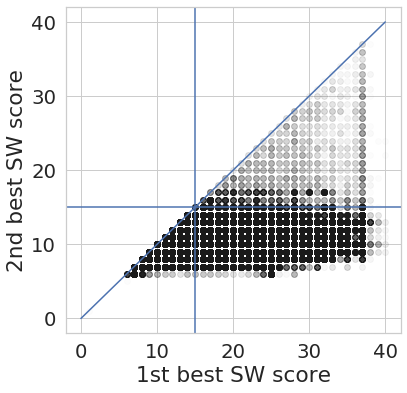

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

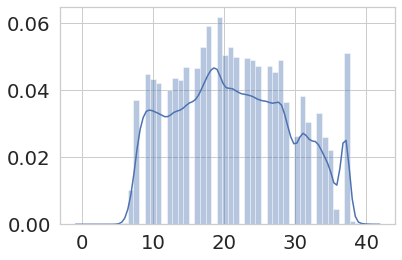

In [17]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [18]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [19]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [20]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [21]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/all_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [22]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [23]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

6
['0', '1', '2', '3', '4', '5', '6', '7', '16', '17', '18', '19', '20', '21', '22', '23', '32', '33', '34', '35', '36', '37', '38', '39', '48', '49', '50', '51', '52', '53', '54', '55', '64', '65', '66', '67', '68', '69', '70', '71', '80', '81', '82', '83', '84', '85', '86', '87']
['8', '9', '10', '11', '12', '13', '14', '15', '24', '25', '26', '27', '28', '29', '30', '31', '40', '41', '42', '43', '44', '45', '46', '47', '56', '57', '58', '59', '60', '61', '62', '63', '72', '73', '74', '75', '76', '77', '78', '79', '88', '89', '90', '91', '92', '93', '94', '95', '0', '1', '2', '3', '4', '5', '6', '7', '16', '17', '18', '19', '20', '21', '22', '23', '32', '33', '34', '35', '36', '37', '38', '39', '48', '49', '50', '51', '52', '53', '54', '55', '64', '65', '66', '67', '68', '69', '70', '71', '80', '81', '82', '83', '84', '85', '86', '87']


## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [24]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [25]:
len(accept_molbit)

330013

In [26]:
sum(accept_molbit)

251588

In [27]:
sum(accept_molbit) / len(accept_molbit)

0.7623578465090769

## Extract the best-aligned molbit, across ONLY the extant molbits

In [28]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [29]:
extant_sw = sw.loc[:, extant_sw_cols]

In [30]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [31]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [32]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [33]:
n_extant_is_best

251520

Percentage of well-aligned reads that belong to the true set

In [34]:
n_extant_is_best/len(sw_accepted)

0.999729716838641

Read counts for each molbit

In [35]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 57),
 ('1', 22),
 ('10', 3517),
 ('11', 3851),
 ('12', 11429),
 ('13', 496),
 ('14', 2310),
 ('15', 8987),
 ('16', 55),
 ('17', 46),
 ('18', 30),
 ('19', 84),
 ('2', 64),
 ('20', 62),
 ('21', 41),
 ('22', 63),
 ('23', 56),
 ('24', 896),
 ('25', 2513),
 ('26', 4525),
 ('27', 2424),
 ('28', 1382),
 ('29', 3951),
 ('3', 81),
 ('30', 6168),
 ('31', 8766),
 ('32', 39),
 ('33', 39),
 ('34', 42),
 ('35', 27),
 ('36', 96),
 ('37', 38),
 ('38', 14),
 ('39', 30),
 ('4', 23),
 ('40', 4555),
 ('41', 4059),
 ('42', 3605),
 ('43', 13283),
 ('44', 4035),
 ('45', 5327),
 ('46', 1448),
 ('47', 1915),
 ('48', 66),
 ('49', 163),
 ('5', 46),
 ('50', 58),
 ('51', 92),
 ('52', 27),
 ('53', 71),
 ('54', 49),
 ('55', 66),
 ('56', 2015),
 ('57', 2580),
 ('58', 5972),
 ('59', 1056),
 ('6', 63),
 ('60', 11962),
 ('61', 2115),
 ('62', 3381),
 ('63', 6409),
 ('64', 4),
 ('65', 40),
 ('66', 45),
 ('67', 43),
 ('68', 47),
 ('69', 119),
 ('7', 124),
 ('70', 13),
 ('71', 43),
 ('72', 5712),
 ('73', 2528),
 ('74

In [36]:
print("\n".join([str(x) for x in c]))

57
22
3517
3851
11429
496
2310
8987
55
46
30
84
64
62
41
63
56
896
2513
4525
2424
1382
3951
81
6168
8766
39
39
42
27
96
38
14
30
23
4555
4059
3605
13283
4035
5327
1448
1915
66
163
46
58
92
27
71
49
66
2015
2580
5972
1056
63
11962
2115
3381
6409
4
40
45
43
47
119
124
13
43
5712
2528
11608
5140
476
4079
1088
1031
3178
20
46
32
17
28
95
43
38
4080
16299
35458
4582
1224
5715
1794
4075
6082


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [37]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [38]:
extant_sw = sw.loc[:, extant_sw_cols]

In [39]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [40]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [41]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [42]:
n_extant_is_best

249013

Percentage of well-aligned reads that belong to the true set

In [43]:
n_extant_is_best/len(sw_accepted)

0.9897650126397125

Read counts for each molbit

In [44]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('10', 3562),
 ('11', 3895),
 ('12', 11499),
 ('13', 606),
 ('14', 2435),
 ('15', 9048),
 ('24', 925),
 ('25', 2545),
 ('26', 4552),
 ('27', 2538),
 ('28', 1399),
 ('29', 3991),
 ('30', 6197),
 ('31', 8781),
 ('40', 4615),
 ('41', 4139),
 ('42', 3612),
 ('43', 13336),
 ('44', 4052),
 ('45', 5348),
 ('46', 1495),
 ('47', 1951),
 ('56', 2047),
 ('57', 2601),
 ('58', 6017),
 ('59', 1218),
 ('60', 11968),
 ('61', 2163),
 ('62', 3406),
 ('63', 6436),
 ('72', 5780),
 ('73', 2556),
 ('74', 11615),
 ('75', 5266),
 ('76', 512),
 ('77', 4129),
 ('78', 1121),
 ('79', 1116),
 ('8', 3306),
 ('88', 4091),
 ('89', 16327),
 ('9', 35654),
 ('90', 4588),
 ('91', 1290),
 ('92', 5818),
 ('93', 1805),
 ('94', 4116),
 ('95', 6121)]

In [45]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [46]:
", ".join([str(x) for x in l])

'0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87'

## Get counts for all molbits

In [47]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

57
22
66
81
23
46
63
131
3178
35458
3517
3851
11429
496
2310
8987
55
47
30
84
62
41
71
58
896
2513
4525
2424
1382
3951
6168
8766
39
39
42
28
110
38
14
30
4555
4059
3605
13283
4035
5327
1447
1915
66
193
58
93
28
71
49
66
2015
2580
5968
1056
11962
2114
3379
6409
4
40
45
43
47
119
13
43
5710
2528
11608
5113
476
4079
1088
1019
20
46
32
17
28
95
43
39
4080
16299
4582
1213
5709
1794
4074
6081


# Plot read counts

In [48]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(30, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='k', edgecolor='k',
                         label='never been run on this flowcell'),
                       Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='prev run on flowcell'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='current run on flowcell')]
    leg = ax.legend(handles=legend_elements)
    t1, t2, t3 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
    t3._fontproperties = t1._fontproperties.copy()
    t2.set_weight('bold')
    t3.set_weight('bold')
    t3.set_color("tab:red")
    return ax

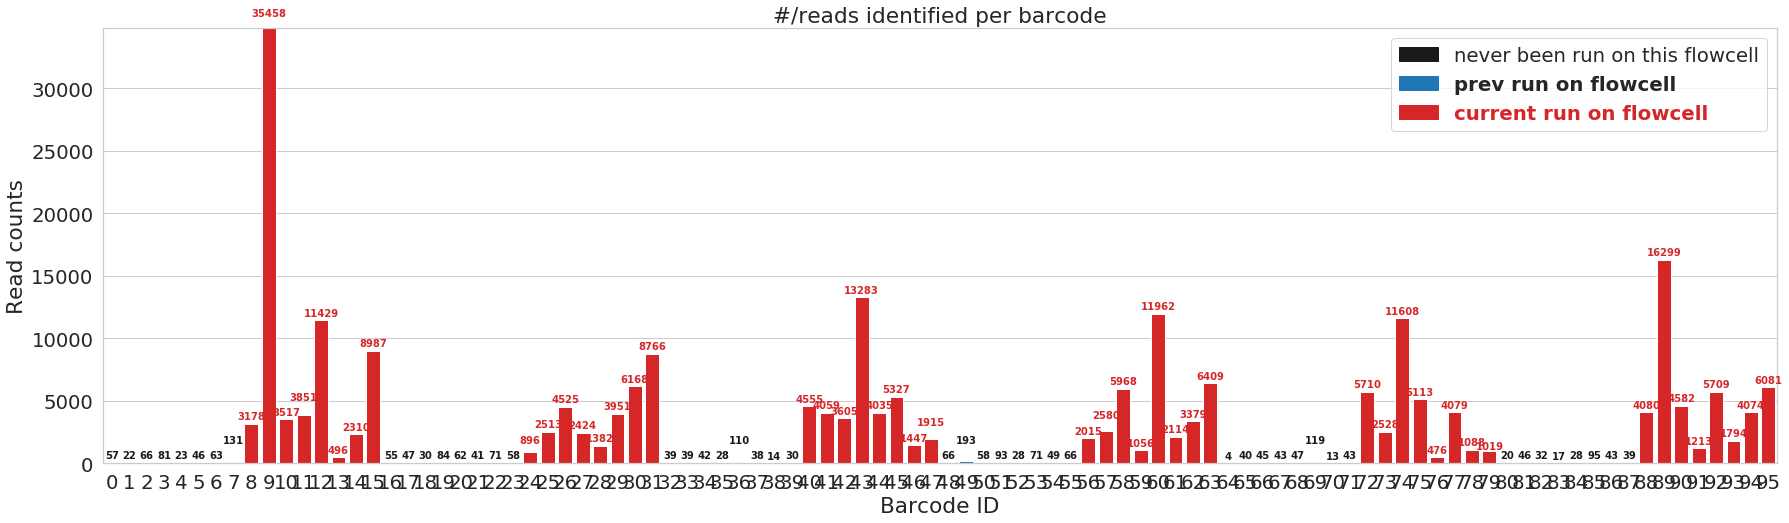

In [54]:
molbits = [str(x) for x in m]
counts = list(c)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=poss_molbits, vmax=34800)

# Save labels

In [50]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/all_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96.tsv'

In [51]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [52]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

/path/to/data/MinION_sequencing_data_20190830/guppy_3.2.2_08_30_2019_run_01_exec_20190830/sw/labels_for_molbits_in_set_ee80935b39ac8eac3e848aa0e1f003f3f7be1c96.tsv


In [53]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
